In [1]:
import pandas as pd
import sqlite3
import datetime
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Connect to DB, load data and convert to dataframe

In [2]:
db_path = "data/twitter_data.db"

In [3]:
conn = sqlite3.connect(db_path)
c = conn.cursor()

In [4]:
c.execute('SELECT SQLITE_VERSION()')

In [5]:
c.execute('SELECT * FROM tweets')
raw_data = c.fetchall()

In [6]:
conn.close()

In [7]:
raw_df = pd.DataFrame(raw_data)
raw_df.columns = ['text', 'username', 'date', 'location']

### Clean Twitter data

In [8]:
raw_df['date'] = pd.to_datetime(raw_df['date'])

In [9]:
import re

def tweet_cleaner(s):    
    s = re.sub(r"http\S+", "", s)
    s = s.replace("’", "'")
    #s = s.replace("'", "")
    s = s.replace("amp", "")
    #s = re.sub(r"\s*[^A-Za-z]+\s*", " ", s)
    #s = s.lower()
    return s

testing = raw_df.text[:]
test_result = []
for t in testing:
    test_result.append(tweet_cleaner(t))

In [10]:
# Combine into dataframe
test = pd.DataFrame(test_result)
test.columns = ['text']
clean_df = pd.concat([test, raw_df['date'], raw_df['location']], axis=1)
clean_df = clean_df[clean_df.text.str.contains('lebron')]
clean_df = clean_df.reset_index(drop=True)

### Date Time Period

In [12]:
# time of tweet #edate = datetime.datetime(2018,7,1,23,0,0)

sdate = datetime.datetime(2018,6,30,23,0,0)
edate = datetime.datetime(2018,7,2,23,0,0)
date_df = []
date_df.append(sdate)

date = sdate
while date < edate:
    date += datetime.timedelta(minutes=1)
    date_df.append(date)

### Tweets per minute

In [13]:
tweet_count = []
tweet_date = []
for i in range(0,len(date_df)-1):
    mask = (clean_df['date'] <= date_df[i+1]) & (clean_df['date'] > date_df[i])
    tweet_count.append(len(clean_df.loc[mask]))
    tweet_date.append(date_df[i])
tweet_count.append(0)

In [14]:
x = range(0,len(tweet_count))
xtickrange=np.arange(min(x), max(x), 500)
dtick=['']
for pos,tick in enumerate(xtickrange):
    dtick.append(str(tweet_date[tick]))
dtick.append(str((tweet_date[500]-tweet_date[0])+tweet_date[tick]))

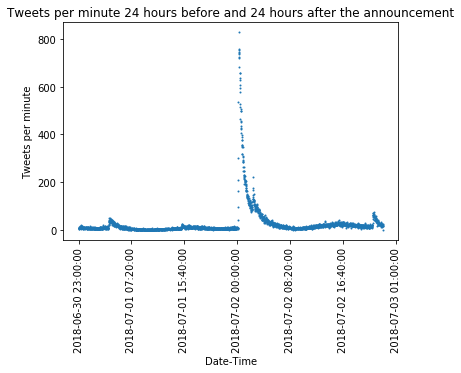

In [15]:
fig, ax = plt.subplots()
fig.canvas.draw()
plt.scatter(x, tweet_count,s=1)
ax.set_xticklabels(dtick)
plt.xticks(rotation=90)
ax.set_xlabel('Date-Time')
ax.set_ylabel('Tweets per minute')
plt.title('Tweets per minute 24 hours before and 24 hours after the announcement')
plt.show()

The scatter graph above presents the number of tweets published per minute that mention 'LeBron'. The data **excludes** retweets and favourites, only tweets explicitly written by users are considered. The date range of the graph is 24 hours before and 24 hours after the annoucement of LeBron's free-agent status. The rate of Tweets per minute (TPM) clearly spikes to a maximum of 829TPM around the time the announcement was made.

### Word cloud

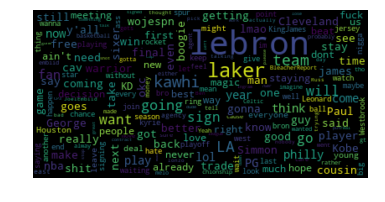

In [24]:
mask = (clean_df['date'] > sdate) & (clean_df['date'] <= datetime.datetime(2018,7,1,23,0,0))
sub_df = clean_df.loc[mask]
sub_df = sub_df.reset_index(drop=True)
single_text=sub_df['text'].str.cat(sep=', ')
text=clean_df['text']
wordcloud = WordCloud(collocations=False).generate(single_text)
# Display the generated image:
import matplotlib.pyplot as plt
wordcloud = WordCloud(collocations=False,max_font_size=40).generate(single_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

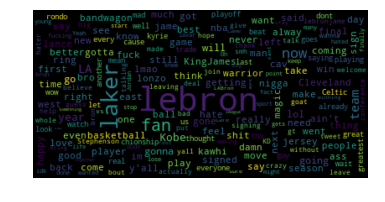

In [25]:
mask = (clean_df['date'] > datetime.datetime(2018,7,1,23,0,0)) & (clean_df['date'] <= edate)
sub_df = clean_df.loc[mask]
sub_df = sub_df.reset_index(drop=True)
single_text=sub_df['text'].str.cat(sep=', ')
text=clean_df['text']
wordcloud = WordCloud(collocations=False).generate(single_text)
# Display the generated image:
import matplotlib.pyplot as plt
wordcloud = WordCloud(collocations=False,max_font_size=40).generate(single_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Sentiment Analysis

In [26]:
sid = SentimentIntensityAnalyzer()

In [35]:
mask = (clean_df['date'] > sdate) & (clean_df['date'] <= edate)
sub_df = clean_df.loc[mask]
sub_df = sub_df.reset_index(drop=True)

In [36]:
sentdata = pd.DataFrame(columns=['neg', 'neu', 'pos', 'compound'])
        
test = sub_df.text[:]

for idxc, sentence in enumerate(test):
    if (idxc%10000)==0:
        print("{0:.2f}".format(idxc/len(test)*100))
    ss = sid.polarity_scores(sentence)
    sentdata = sentdata.append(pd.DataFrame(ss, index=[0]))
sentdata = sentdata.reset_index(drop=True)
print("100")

0.00
12.87
25.75
38.62
51.50
64.37
77.25
90.12
100


In [28]:
sdate = datetime.datetime(2018,6,30,23,0,0)
edate = datetime.datetime(2018,7,2,23,0,0)
date_df = []
date_df.append(sdate)

date = sdate
while date < edate:
    date += datetime.timedelta(minutes=1)
    date_df.append(date)

In [54]:
tweet_sent=[]
for i in range(0,len(date_df)-1):
    mask = (sub_df['date'] <= date_df[i+1]) & (sub_df['date'] > date_df[i])
    temp=sentdata.loc[mask]['compound'].copy()
    temp[temp == 0] = np.nan
    res = np.nanmean(temp)
    tweet_sent.append(res)

C:\Users\bachtia2\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


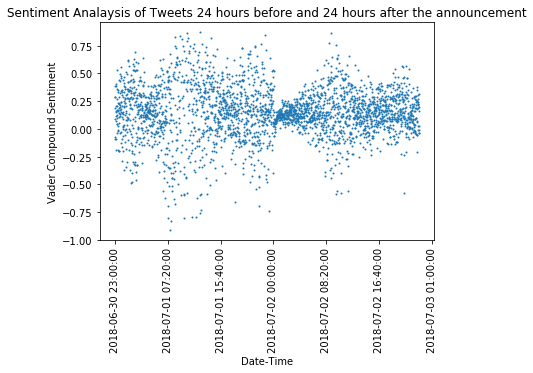

In [59]:
fig, ax = plt.subplots()
fig.canvas.draw()
x = range(0,len(tweet_sent))
plt.scatter(x, tweet_sent,s=1)
ax.set_xticklabels(dtick)
plt.xticks(rotation=90)
ax.set_xlabel('Date-Time')
ax.set_ylabel('Vader Compound Sentiment')
plt.title('Sentiment Analaysis of Tweets 24 hours before and 24 hours after the announcement')
plt.show()

C:\Users\bachtia2\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


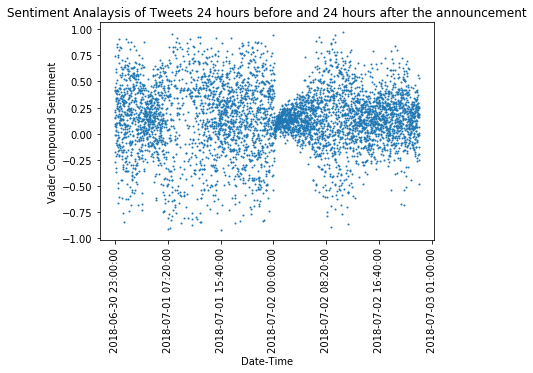

In [61]:
sdate = datetime.datetime(2018,6,30,23,0,0)
edate = datetime.datetime(2018,7,2,23,0,0)
date_df = []
date_df.append(sdate)

date = sdate
while date < edate:
    date += datetime.timedelta(seconds=30)
    date_df.append(date)
    
tweet_sent=[]
for i in range(0,len(date_df)-1):
    mask = (sub_df['date'] <= date_df[i+1]) & (sub_df['date'] > date_df[i])
    temp=sentdata.loc[mask]['compound'].copy()
    temp[temp == 0] = np.nan
    res = np.nanmean(temp)
    tweet_sent.append(res)

fig, ax = plt.subplots()
fig.canvas.draw()
x = range(0,len(tweet_sent))
plt.scatter(x, tweet_sent,s=1)
ax.set_xticklabels(dtick)
plt.xticks(rotation=90)
ax.set_xlabel('Date-Time')
ax.set_ylabel('Vader Compound Sentiment')
plt.title('Sentiment Analaysis of Tweets 24 hours before and 24 hours after the announcement')
plt.show()

### Wordcloud of Sentiment Data

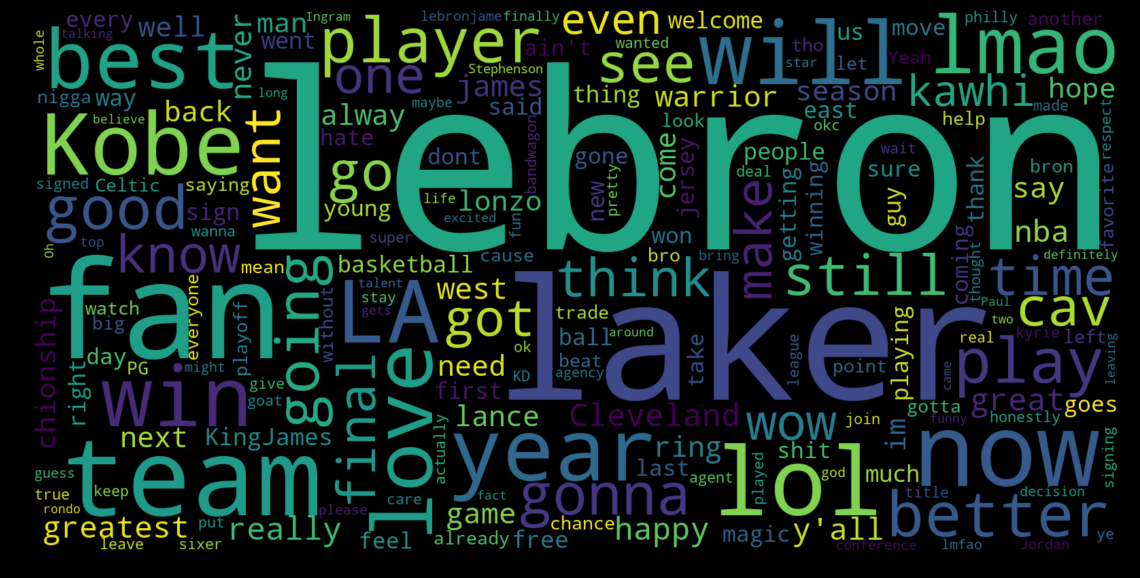

In [95]:
mask = (sentdata['compound'] > 0.5)
temp=sub_df.loc[mask]['text'].copy()
single_text=temp.str.cat(sep=', ')
text=clean_df['text']
# Display the generated image:
import matplotlib.pyplot as plt
wordcloud = WordCloud(collocations=False,width=1600, height=800,random_state=42).generate(single_text)
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('goodcloud.png', facecolor='k', bbox_inches='tight')
plt.show()

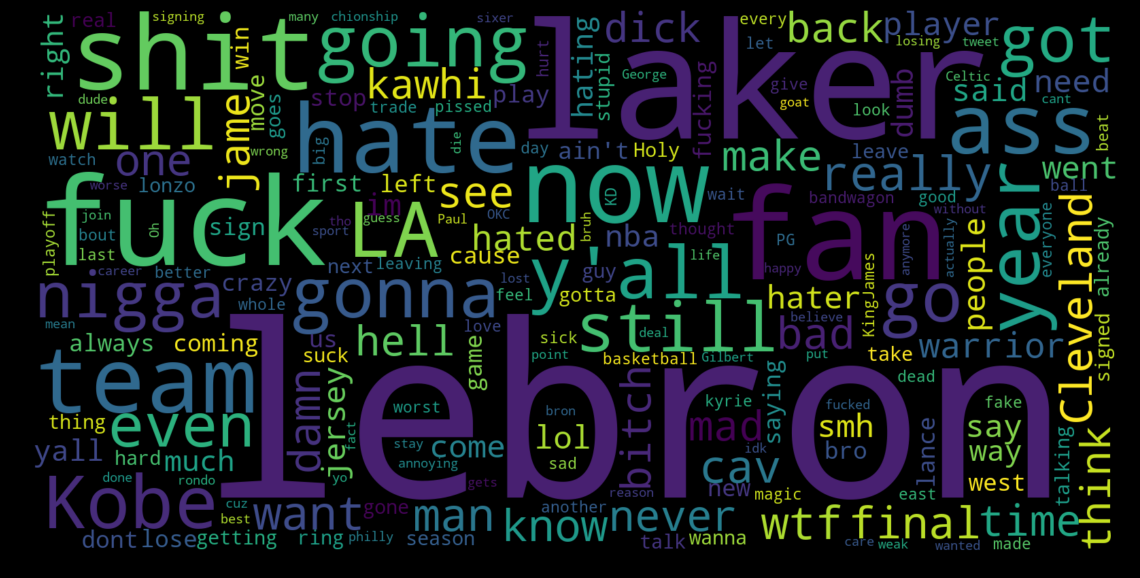

In [94]:
mask = (sentdata['compound'] < -0.5)
temp=sub_df.loc[mask]['text'].copy()
single_text=temp.str.cat(sep=', ')
text=clean_df['text']
# Display the generated image:
import matplotlib.pyplot as plt
wordcloud = WordCloud(collocations=False,width=1600, height=800,random_state=42).generate(single_text)
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('badcloud.png', facecolor='k', bbox_inches='tight')
plt.show()